In [1]:
import kagglehub

path = kagglehub.dataset_download("kenny3s/casia-webface")

print("Path to dataset files:", path)
path=path+"/datasets"

100%|██████████| 1.03G/1.03G [00:29<00:00, 37.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kenny3s/casia-webface/versions/1


In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_images(path):
    images = []
    labels = []
    counter = 0

    for label in os.listdir(path):
        folder_path = os.path.join(path, label)

        # Skip if not a directory
        if not os.path.isdir(folder_path):
            continue

        if len(os.listdir(folder_path)) < 350:
            continue
        else:
            for img in os.listdir(folder_path):
                image_path = os.path.join(folder_path, img)

                # Skip if the file is not an image
                if not os.path.isfile(image_path):
                    continue

                image = cv.imread(image_path)
                if image is None:  # Skip corrupted or unreadable files
                    print(f"Skipping {image_path}, image not loaded.")
                    continue

                image = cv.resize(image, (64, 64))  # Resize all images to a fixed size
                images.append(image)
                labels.append(label)

            counter += 1
            if counter == 51:
                break

    return np.array(images), np.array(labels), counter


In [4]:
image, label,counter= load_images(path)

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [6]:
image=image/255
for i in range(0,2):
  mean=np.mean(image[:,:,:,i])
  std=np.std(image[:,:,:,i])
  image[:,:,:,i]=(image[:,:,:,i]-mean)/std

51
0005476


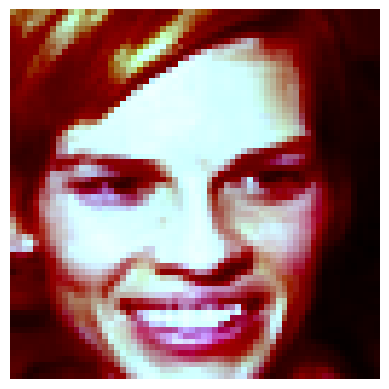

(23487, 64, 64, 3)


In [7]:
print(counter)
plt.imshow(image[105][:,:,::-1])
print(label[105])
plt.axis('off')
plt.show()
print(image.shape)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()


y_encoded = encoder.fit_transform(label)
test_size = 0.15  # 15% of the data for testing
random_state = 42

# Split the data into training and testing sets

image, image_test, y_encoded, y_encoded_test = train_test_split(
    image, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
)

In [12]:
encoder = Sequential([
    Flatten(input_shape=(64,64,3)),
    Dense(512, activation='relu'),  # Latent space
    Dense(1024, activation='relu')  # Latent space
])

# Decoder
decoder = Sequential([
    Dense(1024, activation='relu', input_shape=(1024,)),
    Dense(512, activation='relu'),
    Dense(64 * 64 * 3 , activation='sigmoid'),
    Reshape((64, 64 ,3))  # Reconstruct the original image
])

# Combine into one model
autoencoder = Sequential([encoder, decoder])
autoencoder.summary()

#reporting the model

autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

history_autoencoder=autoencoder.fit(
    image, image,  # Input and target are the same
    epochs=50,  # Adjust based on your dataset and resources
    batch_size=256,
    shuffle=True,
    validation_split=0.25
)


#predict the latent space representation
predictions = autoencoder.predict(image)
latent_representation = encoder.predict(image)
predictions_test = autoencoder.predict(image_test)
latent_representation_test = encoder.predict(image_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1024)                │       6,817,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 64, 64, 3)           │       7,878,144 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,695,424 (56.06 MB)

 Trainable params: 14,695,424 (56.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6721 - loss: 0.5864 - val_accuracy: 0.7790 - val_loss: 0.4637
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7847 - loss: 0.4539 - val_accuracy: 0.8122 - val_loss: 0.4423
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8165 - loss: 0.4343 - val_accuracy: 0.8288 - val_loss: 0.4294
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8337 - loss: 0.4274 - val_accuracy: 0.8299 - val_loss: 0.4246
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8402 - loss: 0.4193 - val_accuracy: 0.8435 - val_loss: 0.4199
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8459 - loss: 0.4178 - val_accuracy: 0.8537 - val_loss: 0.4162
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8515 - loss: 0.4093 - val_accuracy: 0.8559 - val_loss: 0.4136
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8546 - loss: 0.4082 - val_accuracy: 0.8497 - v

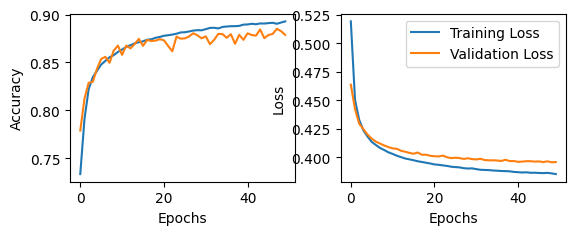

In [13]:
plt.subplot(2, 2, 1)
plt.plot(history_autoencoder.history['accuracy'], label='Training Accuracy')
plt.plot(history_autoencoder.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(2, 2, 2)
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


0.2101971696308095


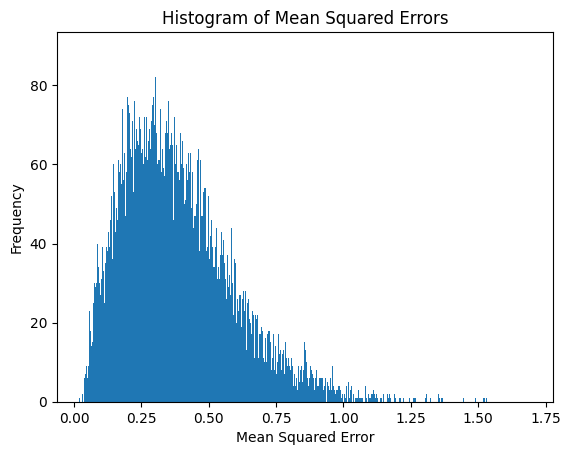

Autoencoder Accuracy: 87.542%


In [14]:
from sklearn.metrics import mean_squared_error


mse=[]
mse = [np.mean((image[i] - predictions[i]) ** 2) for i in range(len(image))]

#remove outlieres in mse
mse=np.array(mse)
std=np.std(mse)
print(std)

threshold = mean+std

#draw the histogram
plt.hist(mse, bins=1000)
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Squared Errors')
plt.show()



# Define a threshold for considering a reconstruction as accurate
#threshold = mean  # Adjust this value based on your requirements

# Calculate the accuracy
accurate_reconstructions = np.sum(mse < threshold)
accuracy = accurate_reconstructions / len(image)

print(f'Autoencoder Accuracy: {accuracy * 100:.3f}%')


In [15]:
n = 10  # Number of images to display
order = np.random.randint(0, image.shape[0], n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


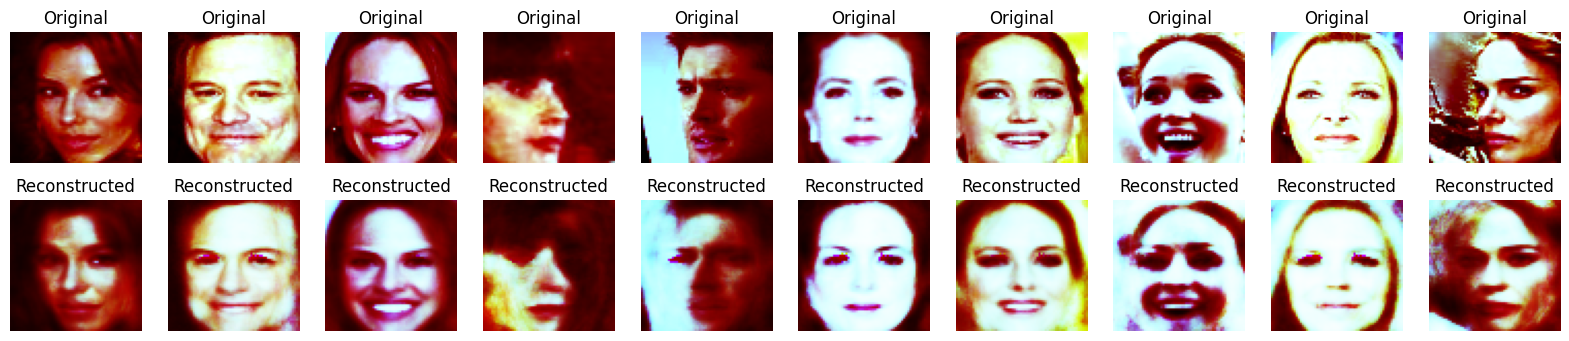

In [16]:
import matplotlib.pyplot as plt

# Pick random test images

predictions = autoencoder.predict(image[order])


# Plot original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    plt.subplot(2, n, i + 1)
    plt.imshow(image[order[i]][:,:,::-1], cmap='gray')  # Adjust size
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, n, n + i + 1)
    plt.imshow(predictions[i][:,:,::-1], cmap='gray')  # Adjust size
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


In [17]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()


# Shuffle the images and labels


latent_representation = (latent_representation- np.mean(latent_representation))/np.std(latent_representation)




model = keras.Sequential([
    Flatten(input_shape=(1024,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



history=model.fit(
    latent_representation, y_encoded,
    epochs=15,
    batch_size=1024,
    validation_split=0.5
)


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.0683 - loss: 3.9070 - val_accuracy: 0.1891 - val_loss: 3.3199
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2316 - loss: 3.1087 - val_accuracy: 0.2991 - val_loss: 2.8000
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3564 - loss: 2.5478 - val_accuracy: 0.3905 - val_loss: 2.4149
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4620 - loss: 2.1690 - val_accuracy: 0.4560 - val_loss: 2.1869
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5387 - loss: 1.8859 - val_accuracy: 0.4981 - val_loss: 2.0199
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5880 - loss: 1.6984 - val_accuracy: 0.5326 - val_loss: 1.9057
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6358 - loss: 1.5053 - val_accuracy: 0.5470 - val_loss: 1.8337
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6624 - loss: 1.3963 - val_accuracy: 0.5585 - val

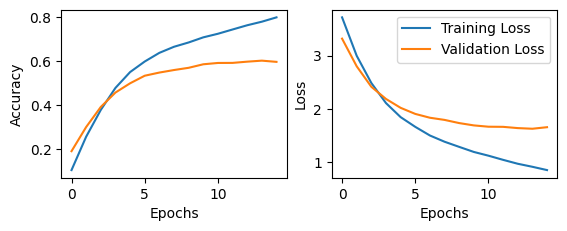

In [18]:
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
model.evaluate(latent_representation_test,y_encoded_test)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3730 - loss: 7.5384


[7.571479320526123, 0.3748581111431122]

In [20]:
import numpy as np

def centroids(train, labels):
    centroids = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        class_centroid = np.mean(train[indices], axis=0)
        centroids.append(class_centroid)
    return np.array(centroids), unique_labels

def predict(test, centroids, unique_labels):
    # Vectorize the distance computation
    distances = np.linalg.norm(test[:, np.newaxis] - centroids, axis=2)  # Shape (n_test, n_centroids)
    closest_centroids = np.argmin(distances, axis=1)  # Get index of closest centroid
    return unique_labels[closest_centroids]

def accuracy(predictions, labels):
    return np.mean(predictions == labels)


In [21]:
latent_representation_test = (latent_representation_test- np.mean(latent_representation_test))/np.std(latent_representation_test)
centroids_train, unique_labels = centroids(latent_representation, y_encoded)
predictions = predict(latent_representation_test, centroids_train, unique_labels)
acc = accuracy(predictions, y_encoded_test)

print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 32.63%


In [22]:
import cv2 as cv
import numpy as np
from skimage.feature import local_binary_pattern
from scipy.stats import mode
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score , confusion_matrix
def confusion_image(label_test, y_test_pred, cutoff=1):
    # Step 1: Compute the confusion matrix
    cm = confusion_matrix(label_test, y_test_pred)

    # Step 2: Normalize the confusion matrix to range [0, 255]
    cm_normalized = (cm / cm.max()) * 255
    cm_image = Image.fromarray(cm_normalized.astype('uint8'))

    # Step 3: Apply contrast stretching
    cm_image = ImageOps.autocontrast(cm_image, cutoff=cutoff)

    # Step 4: Plot the confusion matrix
    plt.imshow(cm_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Step 5: Calculate and return accuracy
    accuracy = (cm.diagonal().sum()) / cm.sum()
    print("Accuracy:", accuracy)


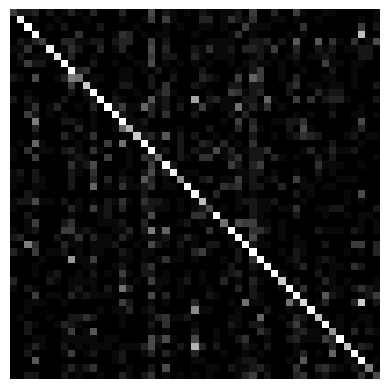

Accuracy: 0.3263337116912599


In [23]:
confusion_image(y_encoded_test, predictions)